In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
flower_data = "archive/flowers"
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)


In [3]:

flower_dataset = ImageFolder(flower_data, transform=transformer)

In [4]:
len(flower_dataset)

4317

In [5]:
classes = os.listdir(flower_data)
print(classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [6]:
#we have Five Class in the dataset, Let's see how many flowers in each Class
def flower_count(base_path):
    """
    basepath - flower Folder path
    return - dict {class_label :count(image)}

  """
    flower_classes = os.listdir(base_path)

    class_count = dict()
    for class_label in flower_classes:
    #Join the Current Flower path and counting length of class label
        class_count[class_label] = len(os.listdir(os.path.join(base_path , class_label)))
    return class_count 

class_count = flower_count(flower_data) 
class_count

# x=
# y=

# sns.set_style('whitegrid')
# plt.figure(figsize = (14,7))
# fig = sns.countplot(x = y, palette = "pastel")
# fig.set(xticks = range(len(classes)), xticklabels = [i for i in classes])
# plt.xlabel('Type of Flower')
# plt.ylabel('Count')

# for p in fig.patches:
#         fig.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()))
# plt.show()

{'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}

In [7]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

In [8]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def show_sample(image, label,invert=True):
    print("Label :" +flower_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :daisy(0)


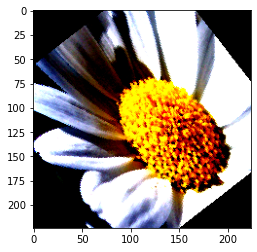

In [9]:
show_sample(*flower_dataset[1])


In [10]:
flower_validation_size = 500
flower_training_size = len(flower_dataset) - flower_validation_size

In [11]:
flower_train_data, flower_val_data_main = random_split(flower_dataset,[flower_training_size, flower_validation_size])
flower_val_data, flower_test_data  = random_split(flower_val_data_main,[300, 00])
len(flower_train_data), len(flower_val_data), len(flower_test_data)

(3317, 300, 700)

In [12]:
batch_size=35


In [13]:
flower_train_dataloader = DataLoader(flower_train_data, batch_size , shuffle=True)
flower_val_dataloader = DataLoader(flower_val_data,batch_size)
flower_test_dataloader = DataLoader(flower_test_data, batch_size)

In [14]:
len(flower_train_dataloader), len(flower_val_dataloader), len(flower_test_dataloader)

(95, 9, 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


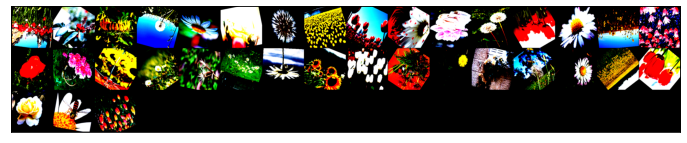

In [15]:
show_batch(flower_train_dataloader,invert=True)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
model = FlowerModel()
model

for images, labels in flower_train_dataloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

    
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


flower_train_dataloader = DeviceDataLoader(flower_train_dataloader, device)
flower_val_dataloader = DeviceDataLoader(flower_val_dataloader, device)
to_device(model, device);

images.shape: torch.Size([35, 3, 224, 224])
out.shape: torch.Size([35, 5])
out[0]: tensor([-0.0286, -0.0275,  0.0005, -0.0113, -0.0274],
       grad_fn=<SelectBackward0>)


In [21]:
model = to_device(FlowerModel(), device)
evaluate(model, flower_val_dataloader)

{'val_loss': 1.6131534576416016, 'val_acc': 0.16587302088737488}

In [22]:
epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [23]:
%%time
try1 = fit(epochs, lr, model, flower_train_dataloader, flower_val_dataloader, opt_func)

Epoch [0], train_loss: 1.5406, val_loss: 1.4193, val_acc: 0.3127
Epoch [1], train_loss: 1.3406, val_loss: 1.2056, val_acc: 0.4738
Epoch [2], train_loss: 1.1287, val_loss: 1.0961, val_acc: 0.6008
Epoch [3], train_loss: 1.0634, val_loss: 0.9741, val_acc: 0.6167
Epoch [4], train_loss: 1.0282, val_loss: 0.8897, val_acc: 0.6659
Epoch [5], train_loss: 0.9844, val_loss: 0.8882, val_acc: 0.6437
Epoch [6], train_loss: 0.9585, val_loss: 0.8620, val_acc: 0.6603
Epoch [7], train_loss: 0.9166, val_loss: 0.8340, val_acc: 0.6548
Epoch [8], train_loss: 0.8848, val_loss: 0.7635, val_acc: 0.6841
Epoch [9], train_loss: 0.8629, val_loss: 0.7395, val_acc: 0.7135
Wall time: 3h 46min 19s


In [24]:
test_dl = DeviceDataLoader(flower_test_dataloader, device)
evaluate(model, test_dl)


{'val_loss': 0.816016674041748, 'val_acc': 0.6871428489685059}

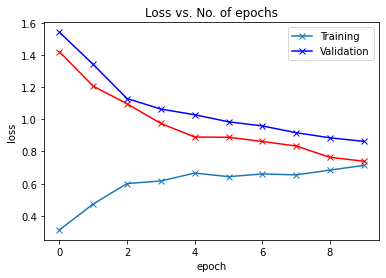

In [25]:
def plot_accuracies(try1):
    accuracies = [x['val_acc'] for x in try1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try1)

def plot_losses(try1):
    train_losses = [x.get('train_loss') for x in try1]
    val_losses = [x['val_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try1)

In [26]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: daisy , Predicted: rose


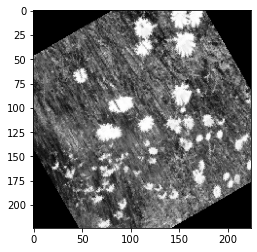

In [27]:
img, label = flower_test_data[1]
plt.imshow(img[0], cmap='gray')
print('Label:', flower_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: sunflower , Predicted: daisy


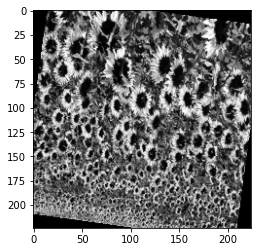

In [28]:
img, label = flower_test_data[5]
plt.imshow(img[0], cmap='gray')
print('Label:', flower_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [30]:
class FlowerModel18(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    



In [31]:
model = to_device(FlowerModel18(), device)
evaluate(model, flower_val_dataloader)

{'val_loss': 1.6070303916931152, 'val_acc': 0.21269840002059937}

In [32]:
num_epochs = 5
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [33]:
%%time
try2 = fit(num_epochs, lr_1, model, flower_train_dataloader, flower_val_dataloader, opt_func_1)

Epoch [0], train_loss: 1.1722, val_loss: 1.3170, val_acc: 0.5254
Epoch [1], train_loss: 1.1303, val_loss: 1.1319, val_acc: 0.7381
Epoch [2], train_loss: 1.1229, val_loss: 1.1048, val_acc: 0.7762
Epoch [3], train_loss: 1.0808, val_loss: 1.2188, val_acc: 0.6754
Epoch [4], train_loss: 1.0814, val_loss: 1.0821, val_acc: 0.7659
Wall time: 39min 1s


In [34]:
%%time
try2 = fit(num_epochs, lr_1, model, flower_train_dataloader, flower_val_dataloader, opt_func_1)

evaluate(model, test_dl)

Epoch [0], train_loss: 1.0953, val_loss: 1.1308, val_acc: 0.7341
Epoch [1], train_loss: 1.0867, val_loss: 1.0727, val_acc: 0.8127
Epoch [2], train_loss: 1.0763, val_loss: 1.1363, val_acc: 0.7381
Epoch [3], train_loss: 1.0813, val_loss: 1.0396, val_acc: 0.8452
Epoch [4], train_loss: 1.0703, val_loss: 1.0386, val_acc: 0.8579
Wall time: 26min 21s


{'val_loss': 1.0843229293823242, 'val_acc': 0.7928572297096252}

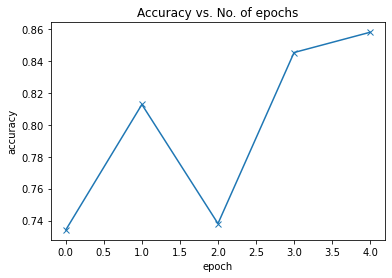

In [35]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

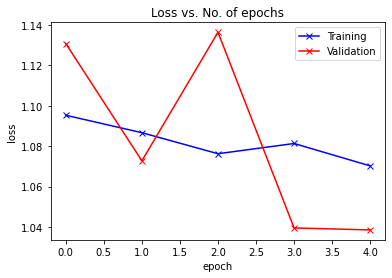

In [36]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

In [37]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: tulip , Predicted: rose


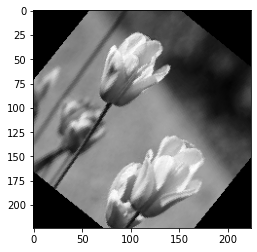

In [38]:
img, label = flower_test_data[17]
plt.imshow(img[0], cmap='gray')
print('Label:', flower_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))

Label: dandelion , Predicted: tulip


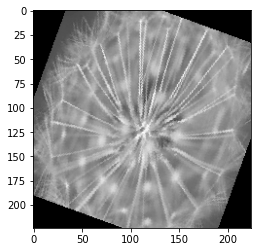

In [39]:
img, label = flower_test_data[10]
plt.imshow(img[0], cmap='gray')
print('Label:', flower_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))

In [ ]:
img, label = flower_test_data[11]
plt.imshow(img[0], cmap='gray')
print('Label:', flower_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))